***Syntax natürlicher Sprachen, WS 2021/22***

---
# Übung 7

In [58]:
import nltk
import sys
from IPython.display import display

# Import necessary only if display() doesnt work (tk is not working properly)
from nltk.tree import Tree

---
## Aufgabe 1 : FCFG: Kongruenz in Nominalphrasen

#### Orientieren Sie sich an folgender Tabelle zur Mehrdeutigkeit der Formen des bestimmen Artikels im Deutschen und passen Sie die Grammatik unten so an, dass sie nur noch grammatikalisch korrekte Nominalphrasen als Teil von Sätzen akzeptiert. Konzentrieren Sie sich auf die Kongruenz von Artikel und Nomen im Genus.

|Form|mögliche Merkmale|
|----|-----------------|
|der|[NUM=sg, GEN=mas, KAS=nom]|
|&nbsp;|[NUM=sg, GEN=fem, KAS=dat]|
|&nbsp;|[NUM=sg, GEN=fem, KAS=GEN]|
|&nbsp;|[NUM=pl, KAS=GEN]|
|die|[NUM=sg, GEN=fem, KAS=nom]|
|&nbsp;|[NUM=sg, GEN=fem, KAS=akk]|
|&nbsp;|[NUM=pl, KAS=nom]|
|&nbsp;|[NUM=pl, KAS=akk]|
|das|[NUM=sg, GEN=neu, KAS=nom]|
|&nbsp;|[NUM=sg, GEN=neu, KAS=akk]|

In [59]:
grammar = """
S -> NP VP

NP -> DET[GEN=?x] NOM[GEN=?x]
NOM[GEN=?x] -> ADJ[GEN=?x] NOM[GEN=?x] | N[GEN=?x]
VP -> V NP NP | V NP | V


DET[GEN=mask] -> "der" 
DET[GEN=fem] -> "die" 
DET[GEN=neut] -> "das"

N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"

V -> "gibt" | "schenkt" | "schläft" | "gefällt" | "kennt"
"""

In [60]:
def test_grammar(grammar, sentences):
    cfg = nltk.grammar.FeatureGrammar.fromstring(grammar)
    parser = nltk.parse.FeatureEarleyChartParser(cfg)
    
    for i, sent in enumerate(sentences, 1):
        print("Satz {}: {}".format(i, sent))
        results = parser.parse(sent.split())
        analyzed = False
        for tree in results:
            #tree = Tree.fromstring(str(tree).replace(", ",","))
            display(tree)
            # if display doesn't work use the following
            #tree.pretty_print(unicodelines=True)
            analyzed = True
        if not analyzed:
            print("Keine Analyse möglich", file=sys.stderr)

In [61]:
pos_sentences = ["der Mann schläft"]
neg_sentences = ["das Mann schläft"]

In [62]:
test_grammar(grammar, neg_sentences)

Satz 1: das Mann schläft


Keine Analyse möglich


Satz 1: der Mann schläft


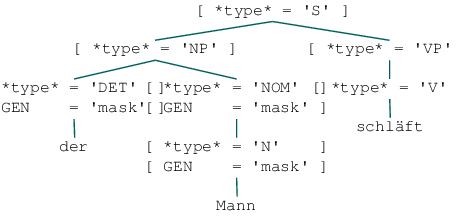

In [63]:
test_grammar(grammar, pos_sentences)

---
## Aufgabe 2: FCFG: Kasus und Subkategorisierung

#### Als nächstes sollen Kasusbedingungen in die Grammatik integriert werden (fügen Sie ggf. neue lexikalische Regeln für die Beispielsätze hinzu):

1. Es gibt nur eine Nominalphrase im Nominativ (Subjekt).
1. Je nach Valenzstellen des Verbes sollen nur Nominalphrasen in den korrekten Kasus akzeptiert werden.
1. *Optional:* Versuchen Sie die freie Satzstellung des Deutschen zu berücksichtigen.

In [64]:
pos_sentences.extend([
    "das Buch gefällt der Frau",
    "das Buch kennt die Frau",
    "der Mann gibt der Frau das Buch"
])

neg_sentences.extend([
    "der Mann schläft das Buch",
    "die Frau gefällt das Buch",
    "das Buch kennt",
    "die Frau gibt das Buch"
])

In [65]:
# solution for conditions 1 and 2
grammar = """

S -> NP[CASE=nom] VP

NP[CASE=?y] -> DET[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y]
NOM[GEN=?x,CASE=?y] -> ADJ[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y] | N[GEN=?x]

# intransitive
VP -> V[SUBCAT=intr]
# transitive
VP -> V[SUBCAT=tr, OBJCASE=?x] NP[CASE=?x]
# ditransitive
VP -> V[SUBCAT=ditr, OBJCASE=?x, IOBJCASE=?y] NP[CASE=?y] NP[CASE=?x]


N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"


V[SUBCAT=intr] -> "schläft"
V[SUBCAT=tr,OBJCASE=akk] -> "kennt"
V[SUBCAT=tr,OBJCASE=dat] -> "gefällt"
V[SUBCAT=ditr, OBJCASE=akk, IOBJCASE=dat] -> "gibt" | "schenkt"


DET[GEN=mask,CASE=nom] -> "der" 
DET[GEN=mask,CASE=akk] -> "den" 
DET[GEN=mask,CASE=dat] -> "dem" 
DET[GEN=fem,CASE=nom] -> "die" 
DET[GEN=fem,CASE=akk] -> "die" 
DET[GEN=fem,CASE=dat] -> "der" 
DET[GEN=neut,CASE=nom] -> "das"
DET[GEN=neut,CASE=akk] -> "das"
DET[GEN=neut,CASE=dat] -> "dem"


"""

In [66]:
test_grammar(grammar, neg_sentences)

Satz 1: das Mann schläft
Satz 2: der Mann schläft das Buch
Satz 3: die Frau gefällt das Buch
Satz 4: das Buch kennt
Satz 5: die Frau gibt das Buch


Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich


Satz 1: der Mann schläft


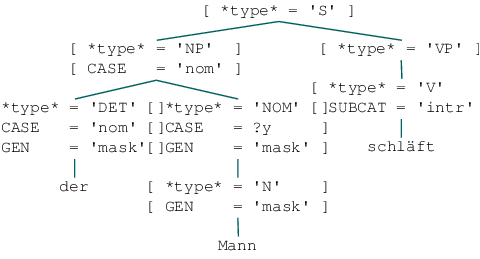

Satz 2: das Buch gefällt der Frau


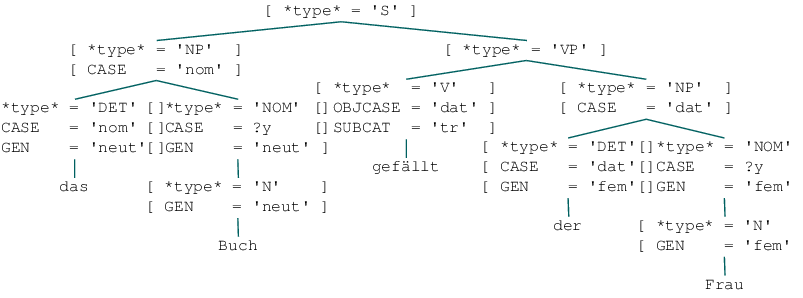

Satz 3: das Buch kennt die Frau


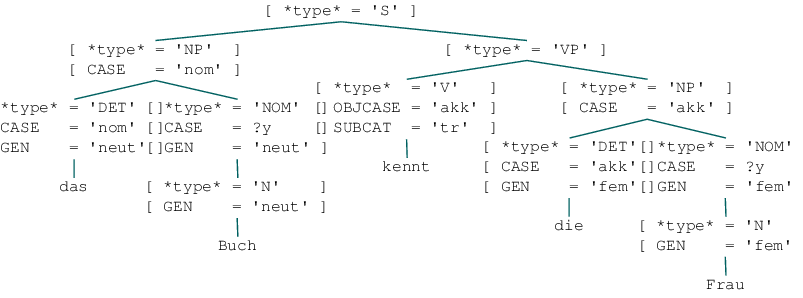

Satz 4: der Mann gibt der Frau das Buch


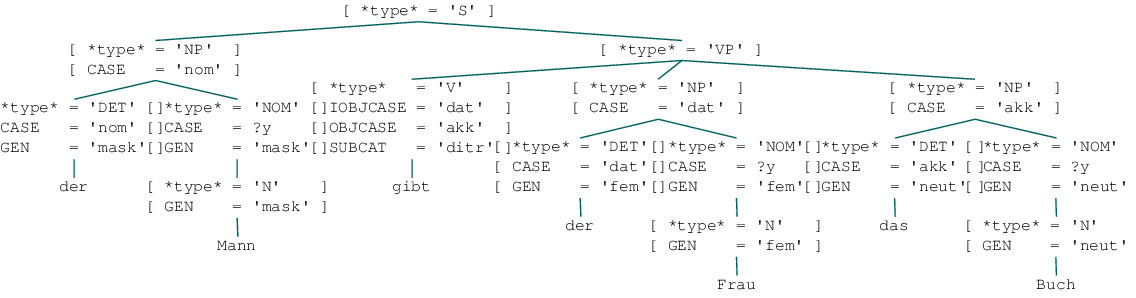

In [67]:
test_grammar(grammar, pos_sentences)

In [68]:
# solution for condition 3

grammar = """

# intransitiv ("der Mann schläft")
S -> NP[CASE=?s] V[SUBCAT=intr, SBJCASE=?s]

# transitiv ("die Frau kennt den Mann" vs "den Mann kennt die Frau")
S -> NP[CASE=?s] V[SUBCAT=tr, SBJCASE=?s, OBJCASE=?o] NP[CASE=?o]
S -> NP[CASE=?o] V[SUBCAT=tr, SBJCASE=?s, OBJCASE=?o] NP[CASE=?s]

# ditransitiv ("der Mann gibt der Frau das Buch" vs "der Mann gibt das buch der Frau")
S -> NP[CASE=?s] V[SUBCAT=ditr, SBJCASE=?s, IOBJCASE=?io, OBJCASE=?o] NP[CASE=?io] NP[CASE=?o]
S -> NP[CASE=?s] V[SUBCAT=ditr, SBJCASE=?s, IOBJCASE=?io, OBJCASE=?o] NP[CASE=?o] NP[CASE=?io]

# ditransitiv ("der Frau gibt der Mann das Buch" vs "das Buch gibt der Mann der Frau")
S -> NP[CASE=?io] V[SUBCAT=ditr, SBJCASE=?s, IOBJCASE=?io, OBJCASE=?o] NP[CASE=?s] NP[CASE=?o]
S -> NP[CASE=?o] V[SUBCAT=ditr, SBJCASE=?s, IOBJCASE=?io, OBJCASE=?o] NP[CASE=?s] NP[CASE=?io]


NP[CASE=?y] -> DET[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y]
NOM[GEN=?x,CASE=?y] -> ADJ[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y] | N[GEN=?x]


N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"


V[SUBCAT=intr,SUBJCASE=nom] -> "schläft"
V[SUBCAT=tr,SBJCASE=nom,OBJCASE=akk] -> "kennt"
V[SUBCAT=tr,SBJCASE=nom,OBJCASE=dat] -> "gefällt"
V[SUBCAT=ditr,SBJCASE=nom,OBJCASE=akk,IOBJCASE=dat] -> "gibt" | "schenkt"


DET[GEN=mask,CASE=nom] -> "der" 
DET[GEN=mask,CASE=akk] -> "den" 
DET[GEN=mask,CASE=dat] -> "dem" 
DET[GEN=fem,CASE=nom] -> "die" 
DET[GEN=fem,CASE=akk] -> "die" 
DET[GEN=fem,CASE=dat] -> "der" 
DET[GEN=neut,CASE=nom] -> "das"
DET[GEN=neut,CASE=akk] -> "das"
DET[GEN=neut,CASE=dat] -> "dem"


"""

Satz 1: den Mann kennt die Frau


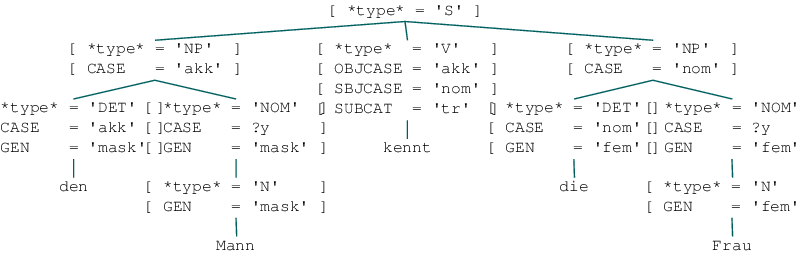

In [69]:
test_grammar(grammar, ["den Mann kennt die Frau"])

Satz 1: der Mann gibt das Buch der Frau


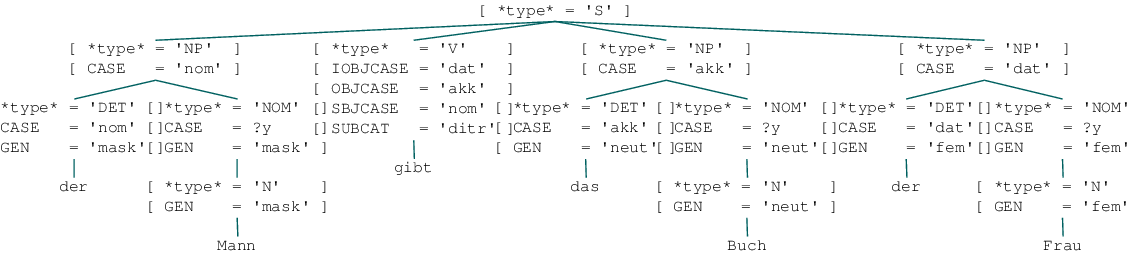

In [70]:
test_grammar(grammar, ["der Mann gibt das Buch der Frau"])

Satz 1: der Frau gibt der Mann das Buch


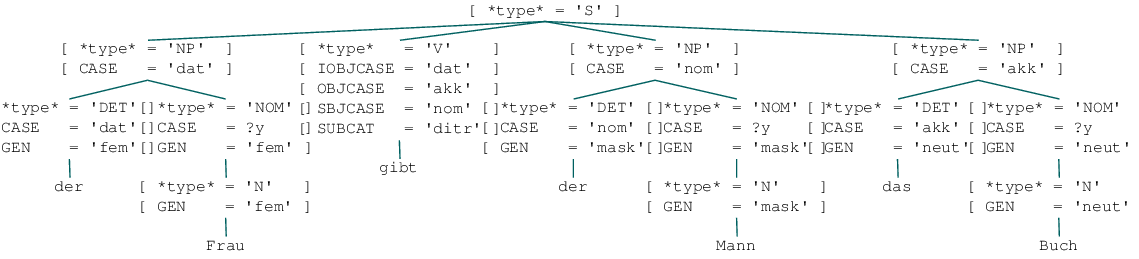

In [71]:
test_grammar(grammar, ["der Frau gibt der Mann das Buch"])

Satz 1: das Buch gibt der Mann der Frau


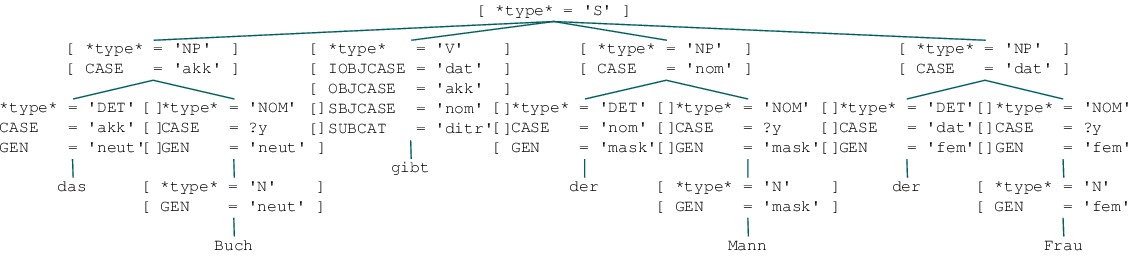

In [72]:
test_grammar(grammar, ["das Buch gibt der Mann der Frau"])

---
## Aufgabe 3: Plural-Agreement für Subjekt und Verb

#### Ergänzen Sie untenstehende Grammatik um die Möglichkeit, das Subjekt in den Plural zu setzen.

#### Dafür müssen Sie folgendes tun:
  1. Erstellen Sie lexikalische Regeln für Pluralformen der Verben, Adjektive und Substantive (Nominativ ist ausreichend.).
  1. Vervollständigen Sie die lexikalischen Regeln für die Form des Artikels *die* um die korrekte Merkmalstruktur für den Plural.
  1. Formulieren Sie eine Kongruenzbedingung in Numerus zwischen Verb und Subjekt.

In [73]:
grammar = """

S -> NP[CASE=nom,NUM=?x] VP[NUM=?x]

NP[CASE=?y,NUM=?z] -> DET[GEN=?x,CASE=?y,NUM=?z] NOM[GEN=?x,CASE=?y,NUM=?z]
NOM[GEN=?x,NUM=?z] -> ADJ[GEN=?x,NUM=?z] NOM[GEN=?x,NUM=?z] | N[GEN=?x,NUM=?z]

# intransitive
VP[NUM=?z] -> V[SUBCAT=intr,NUM=?z]
# transitive
VP[NUM=?z] -> V[SUBCAT=tr, OBJCASE=?x, NUM=?z] NP[CASE=?x]
# ditransitive
VP[NUM=?z] -> V[SUBCAT=ditr, OBJCASE=?x, IOBJCASE=?y, NUM=?z] NP[CASE=?y] NP[CASE=?x]



N[GEN=mask,NUM=sg] -> "Mann"
N[GEN=mask,NUM=pl] -> "Männer"
N[GEN=fem,NUM=sg] -> "Frau"
N[GEN=fem,NUM=pl] -> "Frauen"
N[GEN=neut,NUM=sg] -> "Buch"
N[GEN=neut,NUM=pl] -> "Bücher"


V[SUBCAT=intr,NUM=sg] -> "schläft"
V[SUBCAT=intr,NUM=pl] -> "schlafen"
V[SUBCAT=tr,OBJCASE=akk,NUM=sg] -> "kennt"
V[SUBCAT=tr,OBJCASE=akk,NUM=pl] -> "kennen"
V[SUBCAT=tr,OBJCASE=dat,NUM=sg] -> "gefällt"
V[SUBCAT=tr,OBJCASE=dat,NUM=pl] -> "gefallen"
V[SUBCAT=ditr, OBJCASE=akk, IOBJCASE=dat,NUM=sg] -> "gibt" | "schenkt"
V[SUBCAT=ditr, OBJCASE=akk, IOBJCASE=dat,NUM=pl] -> "geben" | "schenken"


DET[GEN=mask,CASE=nom,NUM=sg] -> "der" 
DET[GEN=mask,CASE=akk,NUM=sg] -> "den" 
DET[GEN=fem,CASE=nom,NUM=sg] -> "die" 
DET[GEN=fem,CASE=akk,NUM=sg] -> "die" 
DET[GEN=fem,CASE=dat,NUM=sg] -> "der" 
DET[GEN=neut,CASE=nom,NUM=sg] -> "das"
DET[GEN=neut,CASE=akk,NUM=sg] -> "das"

DET[CASE=nom,NUM=pl] -> "die" 
DET[CASE=akk,NUM=pl] -> "die" 

"""

In [74]:
pos_sentences.extend([
    "die Männer geben der Frau das Buch",
    "die Bücher gefallen der Frau",
    "die Frauen schlafen"
])

neg_sentences.extend([
    "der Mann geben der Frau das Buch",
    "das Buch gefällt der Frauen",
    "die Frauen schläft"
])

Satz 1: der Mann schläft


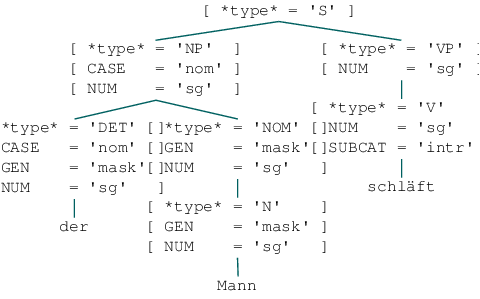

Satz 2: das Buch gefällt der Frau


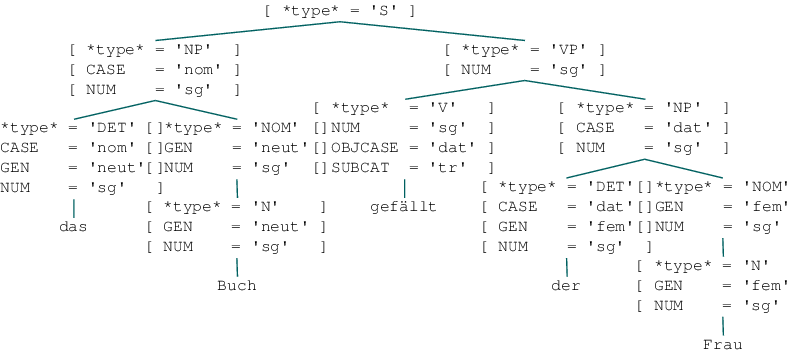

Satz 3: das Buch kennt die Frau


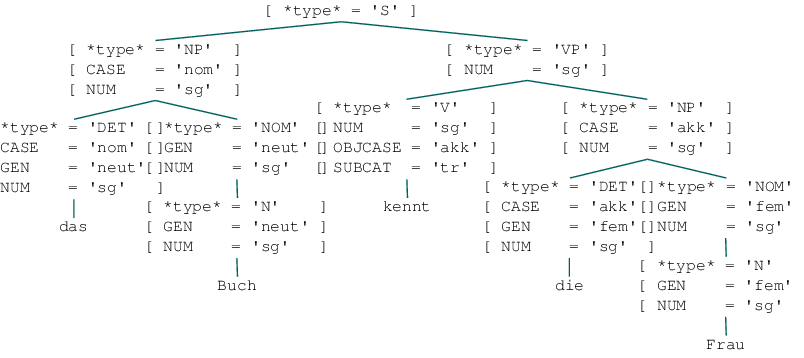

Satz 4: der Mann gibt der Frau das Buch


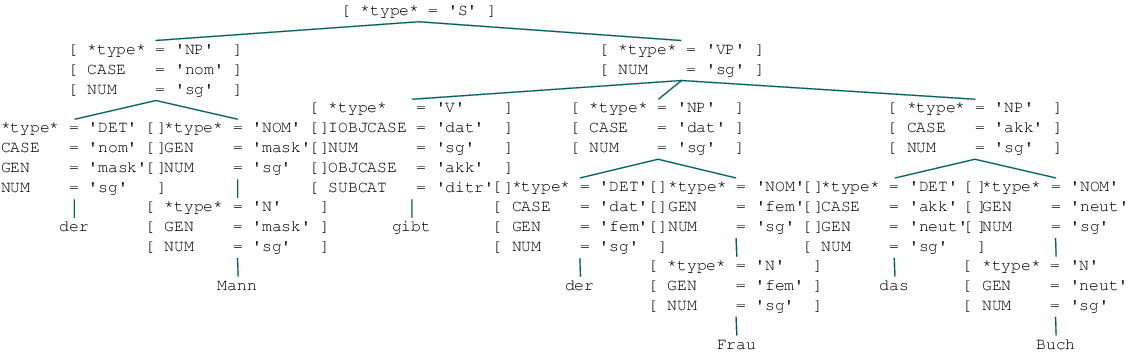

Satz 5: die Männer geben der Frau das Buch


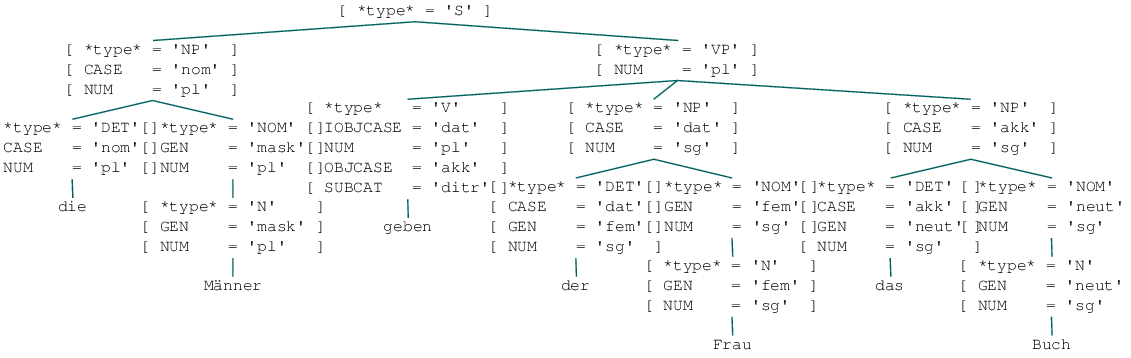

Satz 6: die Bücher gefallen der Frau


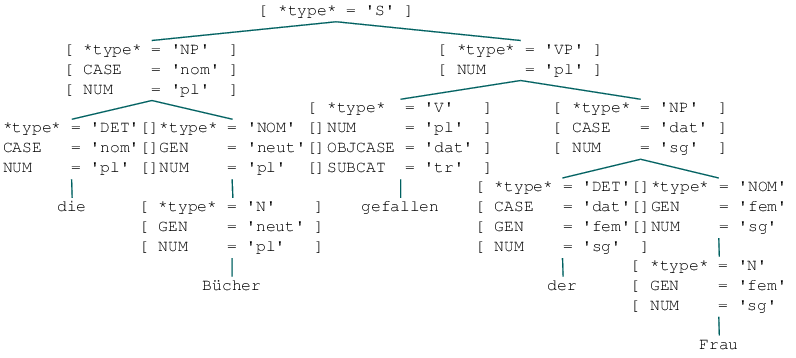

Satz 7: die Frauen schlafen


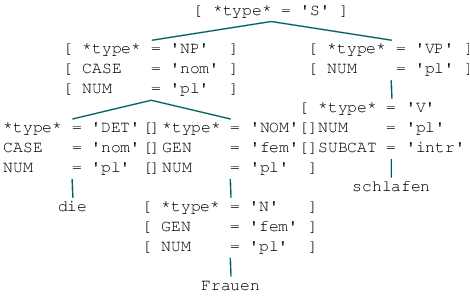

In [75]:
test_grammar(grammar, pos_sentences)

In [76]:
test_grammar(grammar, neg_sentences)

Satz 1: das Mann schläft
Satz 2: der Mann schläft das Buch
Satz 3: die Frau gefällt das Buch
Satz 4: das Buch kennt
Satz 5: die Frau gibt das Buch
Satz 6: der Mann geben der Frau das Buch
Satz 7: das Buch gefällt der Frauen
Satz 8: die Frauen schläft


Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich


--- 
# Hausaufgaben

---
## Aufgabe 4: Adverben und Verbzweitstellung

#### Fügen Sie der Grammatik jetzt die zwei Adverben *heute* und *morgen* hinzu. Adverben können prinzipiell sehr frei im Satz platziert werden. Eine Besonderheit des Deutschen ist aber die sog. Verbzweitstellung, wie sie z. B. in Sätzen wie *Heute schläft der Mann.* deutlich wird.
#### Versuchen Sie alle Möglichkeiten zu implementieren:

In [77]:
grammar = """

BITTE NACH BEARBEITUNG VON (3) VON OBEN KOPIEREN

"""

In [78]:
pos_sentences = [
  "heute gibt der Mann der Frau das Buch",
  "der Mann gibt heute der Frau das Buch",
  "der Mann gibt der Frau heute das Buch",
  "der Mann gibt der Frau das Buch heute"
]

neg_sentences = [
    "heute der Mann gibt der Frau das Buch"
]

In [ ]:
test_grammar(grammar, pos_sentences)

In [ ]:
test_grammar(grammar, neg_sentences)